In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tensorboard
%set_random_seed 12

In [2]:
# %tensorboard --logdir ../offline_rl/ --host localhost

In [3]:
from offline_rl.set_env_variables import set_env_variables

set_env_variables()

import warnings
import os

import gymnasium as gym
from offline_rl.custom_envs.custom_2d_grid_env.obstacles_2D_grid_register import ObstacleTypes
from offline_rl.custom_envs.custom_2d_grid_env.simple_grid import Custom2DGridEnv
from offline_rl.custom_envs.custom_envs_registration import RenderMode
from offline_rl.offline_policies.offpolicy_rendering import offpolicy_rendering
from offline_rl.utils import load_buffer_minari
from offline_rl.visualizations.utils import (
    get_state_action_data_and_policy_grid_distributions,
    snapshot_env,
)
from offline_rl.utils import widget_list
from offline_rl.custom_envs.custom_envs_registration import EnvFactory
from offline_rl.behavior_policies.behavior_policy_registry import BehaviorPolicy2dGridFactory
from offline_rl.generate_custom_minari_datasets.generate_minari_dataset import (
    create_minari_datasets,
)


if not os.environ.get("DISPLAY"):
    os.environ["MUJOCO_GL"] = "egl"

warnings.filterwarnings("ignore")

# To get access to the registered environments.

sys:1: DeprecationWarning: DataCollectorV0 is deprecated and will be removed. Use DataCollector instead.


# Exercise: Minari data collection

In this exercise you don't have any homework. The idea is to play around with it to get familiar with the code  (notebooks and source code) and with the way we collect data.

Remember that the pipeline for offline learning will be the following:

<img src="_static/images/93_offline_RL_pipeline.png" alt="Snow" style="width:50%;">

In this notebook we will be exploring the steps 1-2-3 . It would be a good idea now to give a look to the code structure:

<img src="_static/images/93_code_structure.png" alt="Snow" style="width:20%;">

You can also give a look to [Minari documentation](https://minari.farama.org/main/content/basic_usage/) if needed.

## STEP 1: Create the environments

In [4]:
# List of different environments
ENV_LIST = [
    EnvFactory.Grid_2D_8x8_discrete,
    "InvertedPendulum-v4",
    "Humanoid-v4",
    "AdroitHandHammer-v1",
    "HalfCheetah-v4",
]

# obstacles to be used with the 2d grid-world
grid_world_obstacles = [
    ObstacleTypes.obstacle_8x8_top_right,
    ObstacleTypes.obst_free_8x8,
]

# behavior policies to be used with 2d grid-world
behavior_policy_grid_world = [
    BehaviorPolicy2dGridFactory.suboptimal_8x8,
    BehaviorPolicy2dGridFactory.random,
    BehaviorPolicy2dGridFactory.deterministic_8x8,
]

In [5]:
selected_environment = widget_list(ENV_LIST, description="Mixed envs.")
selected_obstacle = widget_list(grid_world_obstacles, description="grid obst.")
selected_grid_world_policy = widget_list(behavior_policy_grid_world, description="grid policy")

Dropdown(description='Mixed envs.', options=(<EnvFactory.Grid_2D_8x8_discrete: 'Grid_2D_8x8_discrete'>, 'Inver…

Dropdown(description='grid obst.', options=(<ObstacleTypes.obstacle_8x8_top_right: ['00000100', '00000100', '0…

Dropdown(description='grid policy', options=(<BehaviorPolicy2dGridFactory.suboptimal_8x8: 'suboptimal_8x8'>, <…

**Select and render behavior policies**

In [6]:
behavior_policy = BehaviorPolicy2dGridFactory.random
if isinstance(selected_environment.value, EnvFactory):
    env = EnvFactory[selected_environment.value].get_env(render_mode=RenderMode.RGB_ARRAY)
    if isinstance(env.unwrapped, Custom2DGridEnv):
        env.set_new_obstacle_map(selected_obstacle.value.value)
        behavior_policy = selected_grid_world_policy.value
else:
    env = gym.make(selected_environment.value, render_mode="rgb_array")

offpolicy_rendering(
    env_or_env_name=env,
    render_mode=RenderMode.RGB_ARRAY,
    behavior_policy=behavior_policy,
    num_frames=100,
    fps=10,
)

## STEP 2: Create Minari datasets

In [7]:
DATA_SET_IDENTIFIER_I = "_collected_data_nb_92"
NUM_STEPS_I = 500

data_set_config = create_minari_datasets(
    env_name=env.spec.id,
    dataset_identifier=DATA_SET_IDENTIFIER_I,
    num_collected_points=NUM_STEPS_I,
    behavior_policy=behavior_policy,
)

**Congratulations! You have created your first Minari dataset. Take a look at `src/offline_rl/data`.**

## STEP 3: Feed dataset to Tianshou ReplayBuffer

In [8]:
buffer_data = load_buffer_minari(data_set_config.data_set_name)
print(f"The number of dataset points is {len(buffer_data)}")

for elem in buffer_data:
    print(elem)
    break

Dataset /workspace/src/offline_rl/data/offline_data/Grid_2D_8x8_discrete-data_collected_data_nb_92-v0 downloaded. number of episodes: 10
The number of dataset points is 500
Batch(
    obs: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    act: array(1),
    rew: array(-0.01440554),
    terminated: array(False),
    truncated: array(0.),
    done: array(False),
    obs_next: array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    info: Batch(),
    polic

**Let's give a look to the collected 2d grid world data**

**Useful information:**

In our grid world environment, the agent's position is represented as $(x_1, x_2)$, with $x_1/x_2$ the vertical/horizontal coordinates. Observations are represented as a one-hot encoded vector of dimensions $x_1 \times x_2$, for example, a 64-dimensional vector in an 8x8 grid,
 

The action is represented by an integer in the range of [0, 1, 2, 3], each indicating a direction:

    0: (-1, 0) - UP
    1: (1, 0) - DOWN
    2: (0, -1) - LEFT
    3: (0, 1) - RIGHT



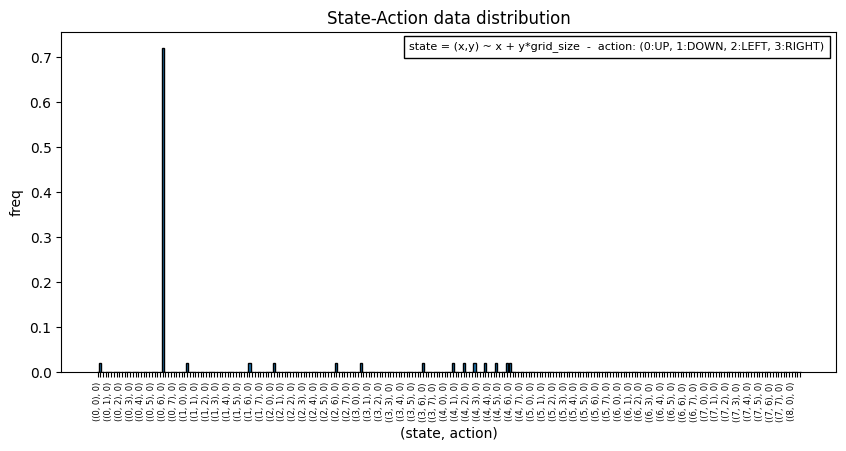

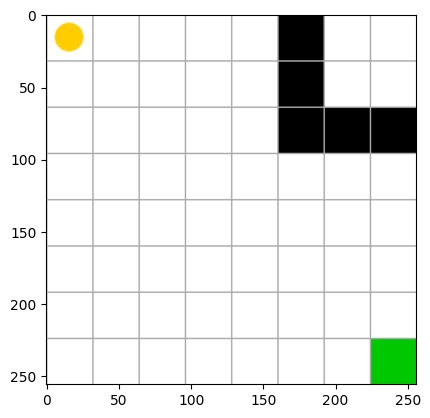

In [9]:
# Compute state-action data distribution
if type(env.unwrapped).__name__== "Custom2DGridEnv":
    state_action_count_data, _ = get_state_action_data_and_policy_grid_distributions(
        buffer_data, env
    )
    snapshot_env(env)
else:
    raise ValueError(f"To analyze the data the environment should be of type {Custom2DGridEnv}.")

## References

[ \[Fu.Justin et. al.\] D4RL: Datasets for Deep Data-Driven Reinforcement Learning](https://arxiv.org/abs/2004.07219)

[ MINARI: A dataset API for Offline Reinforcement Learning ](https://minari.farama.org/main/content/basic_usage/)